In [2]:
import jax
import jax.numpy as jnp

def oscillator(d, w0, x):
    w = jnp.sqrt(w0**2 - d**2)
    phi = jnp.arctan(-d / w)
    A = 1/(2 * jnp.cos(phi))
    cos = jnp.cos(phi + w * x)
    exp = jnp.exp(-d * x)
    y = exp * 2 * A * cos

    return y

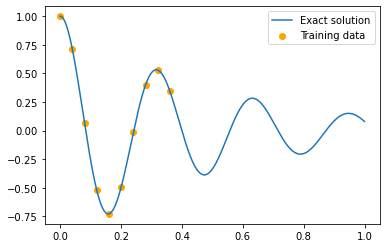

In [3]:
import matplotlib.pyplot as plt

d, w0 = 2, 20

x_total = jnp.linspace(0, 1, 500)
y_total = oscillator(d, w0, x_total)

x_train = x_total[0:200:20]
y_train = y_total[0:200:20]


plt.plot(x_total, y_total, label="Exact solution")
plt.scatter(x_train, y_train, color="orange", label="Training data")
plt.legend()

In [4]:
import haiku as hk
import optax

# Create three layer MLP
def net_fn(x: jnp.ndarray) -> jnp.ndarray:
    mlp = hk.Sequential([
        hk.Linear(32), jax.nn.tanh,
        hk.Linear(32), jax.nn.tanh,
        hk.Linear(32), jax.nn.tanh,
        hk.Linear(1)
    ])
    return mlp(x)

# Calculate mean squared error loss
def loss(params: hk.Params, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
    y_pred = net.apply(params, x)
    mse = jnp.mean((y_pred - y)**2)
    return mse

def update(params: hk.Params, opt_state: optax.OptState, x: jnp.array, y: jnp.array):
    grads = jax.grad(loss)(params, x, y)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state
    

In [5]:
x_train, y_train = x_train.reshape(-1, 1), y_train.reshape(-1, 1)

net = hk.without_apply_rng(hk.transform(net_fn))
opt = optax.adam(1e-3)

params = net.init(jax.random.PRNGKey(42), x_train)
opt_state = opt.init(params)

for i in range(1000):
    params, opt_state = update(params, opt_state, x_train, y_train) 

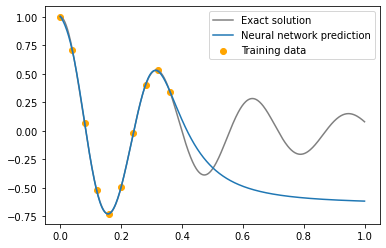

In [6]:
y_pred = net.apply(params, x_total.reshape(-1, 1))
plt.plot(x_total, y_total, color="gray", label="Exact solution")
plt.plot(x_total, y_pred, label="Neural network prediction")
plt.scatter(x_train, y_train, color="orange", label="Training data")
plt.legend()

In [59]:
mu, k = 2 * d, w0**2

def loss_physics(params: hk.Params, x_data: jnp.array, y_data: jnp.array, x_physics: jnp.array):
    y_pred_data = net.apply(params, x_data)
    data_loss = jnp.mean((y_pred_data - y_data)**2)

    # The solution to the differential equation is represented by our network
    u = lambda x: net.apply(params, x)

    # Calculate first and second derivates of network
    u_dx = lambda x: jax.grad(lambda x: jnp.sum(u(x)))(x)
    u_dx2 = lambda x: jax.grad(lambda x: jnp.sum(u_dx(x)))(x)

    # Compute physical loss
    y_pred_physics = net.apply(params, x_physics)
    residual = u_dx2(x_physics) + mu * u_dx(x_physics) + k * y_pred_physics
    physics_loss = (1e-4) * jnp.mean(residual**2)

    return data_loss + physics_loss

def update_physics(params: hk.Params, opt_state: optax.OptState, x_data: jnp.array, y_data: jnp.array, x_physics: jnp.array):
    loss, grads = jax.value_and_grad(loss_physics)(params, x_data, y_data, x_physics)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, loss
    

In [60]:
x_physics = jnp.linspace(0, 1, 30).reshape(-1, 1)

net = hk.without_apply_rng(hk.transform(net_fn))
opt = optax.adam(1e-3)

params = net.init(jax.random.PRNGKey(42), x_train)
opt_state = opt.init(params)

for i in range(20000):
    params, opt_state, loss = update_physics(params, opt_state, x_train, y_train, x_physics)

    if i % 500 == 0:
        print(f"Iteration {i}, loss: {loss}")

Iteration 0, loss: 1.6714400053024292
Iteration 500, loss: 0.30165404081344604
Iteration 1000, loss: 0.18931925296783447
Iteration 1500, loss: 0.03367828205227852
Iteration 2000, loss: 0.017452746629714966
Iteration 2500, loss: 0.01212058961391449
Iteration 3000, loss: 0.010171125642955303
Iteration 3500, loss: 0.00923219881951809
Iteration 4000, loss: 0.008885495364665985
Iteration 4500, loss: 0.008898042142391205
Iteration 5000, loss: 0.008335385471582413
Iteration 5500, loss: 0.007901263423264027
Iteration 6000, loss: 0.007339247968047857
Iteration 6500, loss: 0.00728954840451479
Iteration 7000, loss: 0.00565869128331542
Iteration 7500, loss: 0.00454662786796689
Iteration 8000, loss: 0.0028490000404417515
Iteration 8500, loss: 0.0010930324206128716
Iteration 9000, loss: 0.00047569326125085354
Iteration 9500, loss: 0.00037872607936151326
Iteration 10000, loss: 0.000342794053722173
Iteration 10500, loss: 0.00032078372896648943
Iteration 11000, loss: 0.0003024051256943494
Iteration 115

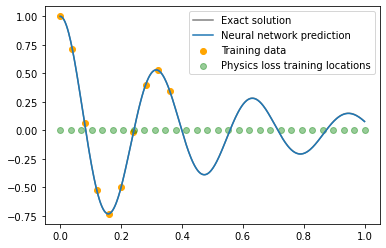

In [64]:
y_pred = net.apply(params, x_total.reshape(-1, 1))
plt.plot(x_total, y_total, color="gray", label="Exact solution")
plt.plot(x_total, y_pred, label="Neural network prediction")
plt.scatter(x_train, y_train, color="orange", label="Training data")
plt.scatter(x_physics, jnp.zeros_like(x_physics), color="green", alpha=0.4, label="Physics loss training locations")
plt.legend()